# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 4251648/11490434 [==========>...................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 13:10 - loss: 0.6949

  30/1875 [..............................] - ETA: 3s - loss: 0.5385   

  62/1875 [..............................] - ETA: 3s - loss: 0.4558

  92/1875 [>.............................] - ETA: 2s - loss: 0.4162

 123/1875 [>.............................] - ETA: 2s - loss: 0.3900

 152/1875 [=>............................] - ETA: 2s - loss: 0.3722

 187/1875 [=>............................] - ETA: 2s - loss: 0.3555

 218/1875 [==>...........................] - ETA: 2s - loss: 0.3435

 249/1875 [==>...........................] - ETA: 2s - loss: 0.3333

 287/1875 [===>..........................] - ETA: 2s - loss: 0.3226

 325/1875 [====>.........................] - ETA: 2s - loss: 0.3133

 361/1875 [====>.........................] - ETA: 2s - loss: 0.3057

 395/1875 [=====>........................] - ETA: 2s - loss: 0.2992

 428/1875 [=====>........................] - ETA: 2s - loss: 0.2935

 462/1875 [======>.......................] - ETA: 2s - loss: 0.2882

 496/1875 [======>.......................] - ETA: 2s - loss: 0.2833

 533/1875 [=======>......................] - ETA: 2s - loss: 0.2783

 569/1875 [========>.....................] - ETA: 1s - loss: 0.2739

 601/1875 [========>.....................] - ETA: 1s - loss: 0.2702

 625/1875 [=========>....................] - ETA: 1s - loss: 0.2676

 645/1875 [=========>....................] - ETA: 1s - loss: 0.2655

 673/1875 [=========>....................] - ETA: 1s - loss: 0.2628

 701/1875 [==========>...................] - ETA: 1s - loss: 0.2601

 730/1875 [==========>...................] - ETA: 1s - loss: 0.2575

 760/1875 [===========>..................] - ETA: 1s - loss: 0.2549

 791/1875 [===========>..................] - ETA: 1s - loss: 0.2523

 824/1875 [============>.................] - ETA: 1s - loss: 0.2497

 855/1875 [============>.................] - ETA: 1s - loss: 0.2474

 888/1875 [=============>................] - ETA: 1s - loss: 0.2451

 920/1875 [=============>................] - ETA: 1s - loss: 0.2429

 951/1875 [==============>...............] - ETA: 1s - loss: 0.2408

 983/1875 [==============>...............] - ETA: 1s - loss: 0.2388

1014/1875 [===============>..............] - ETA: 1s - loss: 0.2369

1046/1875 [===============>..............] - ETA: 1s - loss: 0.2350

1077/1875 [================>.............] - ETA: 1s - loss: 0.2333

1110/1875 [================>.............] - ETA: 1s - loss: 0.2315

1142/1875 [=================>............] - ETA: 1s - loss: 0.2298

1172/1875 [=================>............] - ETA: 1s - loss: 0.2283

1205/1875 [==================>...........] - ETA: 1s - loss: 0.2267

1236/1875 [==================>...........] - ETA: 1s - loss: 0.2252

1268/1875 [===================>..........] - ETA: 0s - loss: 0.2237

1296/1875 [===================>..........] - ETA: 0s - loss: 0.2224

1327/1875 [====================>.........] - ETA: 0s - loss: 0.2211

1352/1875 [====================>.........] - ETA: 0s - loss: 0.2200

1380/1875 [=====================>........] - ETA: 0s - loss: 0.2188

1409/1875 [=====================>........] - ETA: 0s - loss: 0.2177

1438/1875 [======================>.......] - ETA: 0s - loss: 0.2165

1468/1875 [======================>.......] - ETA: 0s - loss: 0.2154

1496/1875 [======================>.......] - ETA: 0s - loss: 0.2143

1524/1875 [=======================>......] - ETA: 0s - loss: 0.2133

1555/1875 [=======================>......] - ETA: 0s - loss: 0.2122

1587/1875 [========================>.....] - ETA: 0s - loss: 0.2110

1612/1875 [========================>.....] - ETA: 0s - loss: 0.2102

1640/1875 [=========================>....] - ETA: 0s - loss: 0.2093

1669/1875 [=========================>....] - ETA: 0s - loss: 0.2083

1702/1875 [==========================>...] - ETA: 0s - loss: 0.2072

1732/1875 [==========================>...] - ETA: 0s - loss: 0.2063

1765/1875 [===========================>..] - ETA: 0s - loss: 0.2053

1790/1875 [===========================>..] - ETA: 0s - loss: 0.2045

1821/1875 [============================>.] - ETA: 0s - loss: 0.2036

1849/1875 [============================>.] - ETA: 0s - loss: 0.2028

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2020


Epoch 2/5
   1/1875 [..............................] - ETA: 5s - loss: 0.1161

  29/1875 [..............................] - ETA: 3s - loss: 0.1094

  57/1875 [..............................] - ETA: 3s - loss: 0.1091

  84/1875 [>.............................] - ETA: 3s - loss: 0.1088

 113/1875 [>.............................] - ETA: 3s - loss: 0.1086

 141/1875 [=>............................] - ETA: 3s - loss: 0.1085

 168/1875 [=>............................] - ETA: 3s - loss: 0.1083

 200/1875 [==>...........................] - ETA: 3s - loss: 0.1083

 229/1875 [==>...........................] - ETA: 2s - loss: 0.1082

 260/1875 [===>..........................] - ETA: 2s - loss: 0.1081

 289/1875 [===>..........................] - ETA: 2s - loss: 0.1080

 321/1875 [====>.........................] - ETA: 2s - loss: 0.1079

 352/1875 [====>.........................] - ETA: 2s - loss: 0.1079

 384/1875 [=====>........................] - ETA: 2s - loss: 0.1078

 402/1875 [=====>........................] - ETA: 2s - loss: 0.1077

 419/1875 [=====>........................] - ETA: 2s - loss: 0.1077

 451/1875 [======>.......................] - ETA: 2s - loss: 0.1076

 482/1875 [======>.......................] - ETA: 2s - loss: 0.1075

 513/1875 [=======>......................] - ETA: 2s - loss: 0.1074

 544/1875 [=======>......................] - ETA: 2s - loss: 0.1074

 577/1875 [========>.....................] - ETA: 2s - loss: 0.1073

 604/1875 [========>.....................] - ETA: 2s - loss: 0.1072

 633/1875 [=========>....................] - ETA: 2s - loss: 0.1071

 663/1875 [=========>....................] - ETA: 2s - loss: 0.1071

 691/1875 [==========>...................] - ETA: 2s - loss: 0.1070

 719/1875 [==========>...................] - ETA: 2s - loss: 0.1069

 749/1875 [==========>...................] - ETA: 2s - loss: 0.1068

 776/1875 [===========>..................] - ETA: 1s - loss: 0.1068

 806/1875 [===========>..................] - ETA: 1s - loss: 0.1067

 834/1875 [============>.................] - ETA: 1s - loss: 0.1067

 865/1875 [============>.................] - ETA: 1s - loss: 0.1066

 892/1875 [=============>................] - ETA: 1s - loss: 0.1065

 924/1875 [=============>................] - ETA: 1s - loss: 0.1065

 956/1875 [==============>...............] - ETA: 1s - loss: 0.1064

 988/1875 [==============>...............] - ETA: 1s - loss: 0.1063

1020/1875 [===============>..............] - ETA: 1s - loss: 0.1063

1051/1875 [===============>..............] - ETA: 1s - loss: 0.1062

1082/1875 [================>.............] - ETA: 1s - loss: 0.1061

1114/1875 [================>.............] - ETA: 1s - loss: 0.1061

1146/1875 [=================>............] - ETA: 1s - loss: 0.1060

1178/1875 [=================>............] - ETA: 1s - loss: 0.1060

1209/1875 [==================>...........] - ETA: 1s - loss: 0.1059

1241/1875 [==================>...........] - ETA: 1s - loss: 0.1058

1272/1875 [===================>..........] - ETA: 1s - loss: 0.1058

1303/1875 [===================>..........] - ETA: 0s - loss: 0.1057

1334/1875 [====================>.........] - ETA: 0s - loss: 0.1057

1365/1875 [====================>.........] - ETA: 0s - loss: 0.1056

1395/1875 [=====================>........] - ETA: 0s - loss: 0.1056

1424/1875 [=====================>........] - ETA: 0s - loss: 0.1055

1452/1875 [======================>.......] - ETA: 0s - loss: 0.1054

1483/1875 [======================>.......] - ETA: 0s - loss: 0.1054

1515/1875 [=======================>......] - ETA: 0s - loss: 0.1053

1546/1875 [=======================>......] - ETA: 0s - loss: 0.1053

1578/1875 [========================>.....] - ETA: 0s - loss: 0.1052

1610/1875 [========================>.....] - ETA: 0s - loss: 0.1052

1642/1875 [=========================>....] - ETA: 0s - loss: 0.1051

1674/1875 [=========================>....] - ETA: 0s - loss: 0.1051

1706/1875 [==========================>...] - ETA: 0s - loss: 0.1050

1738/1875 [==========================>...] - ETA: 0s - loss: 0.1050

1771/1875 [===========================>..] - ETA: 0s - loss: 0.1049

1803/1875 [===========================>..] - ETA: 0s - loss: 0.1049

1836/1875 [============================>.] - ETA: 0s - loss: 0.1048

1869/1875 [============================>.] - ETA: 0s - loss: 0.1048

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1048


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0989

  33/1875 [..............................] - ETA: 2s - loss: 0.0973

  66/1875 [>.............................] - ETA: 2s - loss: 0.0974

  98/1875 [>.............................] - ETA: 2s - loss: 0.0974

 130/1875 [=>............................] - ETA: 2s - loss: 0.0975

 163/1875 [=>............................] - ETA: 2s - loss: 0.0976

 196/1875 [==>...........................] - ETA: 2s - loss: 0.0976

 228/1875 [==>...........................] - ETA: 2s - loss: 0.0976

 261/1875 [===>..........................] - ETA: 2s - loss: 0.0976

 294/1875 [===>..........................] - ETA: 2s - loss: 0.0976

 328/1875 [====>.........................] - ETA: 2s - loss: 0.0976

 361/1875 [====>.........................] - ETA: 2s - loss: 0.0976

 394/1875 [=====>........................] - ETA: 2s - loss: 0.0976

 427/1875 [=====>........................] - ETA: 2s - loss: 0.0976

 459/1875 [======>.......................] - ETA: 2s - loss: 0.0976

 492/1875 [======>.......................] - ETA: 2s - loss: 0.0976

 524/1875 [=======>......................] - ETA: 2s - loss: 0.0976

 556/1875 [=======>......................] - ETA: 2s - loss: 0.0976

 588/1875 [========>.....................] - ETA: 1s - loss: 0.0976

 620/1875 [========>.....................] - ETA: 1s - loss: 0.0976

 653/1875 [=========>....................] - ETA: 1s - loss: 0.0976

 685/1875 [=========>....................] - ETA: 1s - loss: 0.0976

 718/1875 [==========>...................] - ETA: 1s - loss: 0.0976

 747/1875 [==========>...................] - ETA: 1s - loss: 0.0976

 778/1875 [===========>..................] - ETA: 1s - loss: 0.0976

 806/1875 [===========>..................] - ETA: 1s - loss: 0.0976

 837/1875 [============>.................] - ETA: 1s - loss: 0.0975

 865/1875 [============>.................] - ETA: 1s - loss: 0.0975

 899/1875 [=============>................] - ETA: 1s - loss: 0.0975

 930/1875 [=============>................] - ETA: 1s - loss: 0.0975

 964/1875 [==============>...............] - ETA: 1s - loss: 0.0975

 996/1875 [==============>...............] - ETA: 1s - loss: 0.0975

1028/1875 [===============>..............] - ETA: 1s - loss: 0.0975

1060/1875 [===============>..............] - ETA: 1s - loss: 0.0975

1090/1875 [================>.............] - ETA: 1s - loss: 0.0975

1121/1875 [================>.............] - ETA: 1s - loss: 0.0975

1153/1875 [=================>............] - ETA: 1s - loss: 0.0975

1187/1875 [=================>............] - ETA: 1s - loss: 0.0975

1218/1875 [==================>...........] - ETA: 1s - loss: 0.0974

1245/1875 [==================>...........] - ETA: 1s - loss: 0.0974

1276/1875 [===================>..........] - ETA: 0s - loss: 0.0974

1309/1875 [===================>..........] - ETA: 0s - loss: 0.0974

1341/1875 [====================>.........] - ETA: 0s - loss: 0.0974

1373/1875 [====================>.........] - ETA: 0s - loss: 0.0974

1405/1875 [=====================>........] - ETA: 0s - loss: 0.0974

1438/1875 [======================>.......] - ETA: 0s - loss: 0.0974

1470/1875 [======================>.......] - ETA: 0s - loss: 0.0974

1504/1875 [=======================>......] - ETA: 0s - loss: 0.0973

1537/1875 [=======================>......] - ETA: 0s - loss: 0.0973

1562/1875 [=======================>......] - ETA: 0s - loss: 0.0973

1593/1875 [========================>.....] - ETA: 0s - loss: 0.0973

1625/1875 [=========================>....] - ETA: 0s - loss: 0.0973

1656/1875 [=========================>....] - ETA: 0s - loss: 0.0973

1687/1875 [=========================>....] - ETA: 0s - loss: 0.0973

1718/1875 [==========================>...] - ETA: 0s - loss: 0.0973

1747/1875 [==========================>...] - ETA: 0s - loss: 0.0973

1776/1875 [===========================>..] - ETA: 0s - loss: 0.0973

1808/1875 [===========================>..] - ETA: 0s - loss: 0.0973

1841/1875 [============================>.] - ETA: 0s - loss: 0.0973

1872/1875 [============================>.] - ETA: 0s - loss: 0.0972

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0972


Epoch 4/5
   1/1875 [..............................] - ETA: 7s - loss: 0.0954

  33/1875 [..............................] - ETA: 2s - loss: 0.0981

  66/1875 [>.............................] - ETA: 2s - loss: 0.0975

  97/1875 [>.............................] - ETA: 2s - loss: 0.0973

 130/1875 [=>............................] - ETA: 2s - loss: 0.0972

 161/1875 [=>............................] - ETA: 2s - loss: 0.0970

 193/1875 [==>...........................] - ETA: 2s - loss: 0.0969

 222/1875 [==>...........................] - ETA: 2s - loss: 0.0968

 254/1875 [===>..........................] - ETA: 2s - loss: 0.0968

 286/1875 [===>..........................] - ETA: 2s - loss: 0.0967

 318/1875 [====>.........................] - ETA: 2s - loss: 0.0966

 350/1875 [====>.........................] - ETA: 2s - loss: 0.0966

 383/1875 [=====>........................] - ETA: 2s - loss: 0.0965

 415/1875 [=====>........................] - ETA: 2s - loss: 0.0965

 446/1875 [======>.......................] - ETA: 2s - loss: 0.0965

 473/1875 [======>.......................] - ETA: 2s - loss: 0.0964

 500/1875 [=======>......................] - ETA: 2s - loss: 0.0964

 530/1875 [=======>......................] - ETA: 2s - loss: 0.0964

 560/1875 [=======>......................] - ETA: 2s - loss: 0.0964

 588/1875 [========>.....................] - ETA: 2s - loss: 0.0963

 618/1875 [========>.....................] - ETA: 2s - loss: 0.0963

 646/1875 [=========>....................] - ETA: 2s - loss: 0.0963

 676/1875 [=========>....................] - ETA: 1s - loss: 0.0963

 704/1875 [==========>...................] - ETA: 1s - loss: 0.0963

 738/1875 [==========>...................] - ETA: 1s - loss: 0.0962

 762/1875 [===========>..................] - ETA: 1s - loss: 0.0962

 791/1875 [===========>..................] - ETA: 1s - loss: 0.0962

 823/1875 [============>.................] - ETA: 1s - loss: 0.0962

 854/1875 [============>.................] - ETA: 1s - loss: 0.0962

 885/1875 [=============>................] - ETA: 1s - loss: 0.0962

 910/1875 [=============>................] - ETA: 1s - loss: 0.0961

 938/1875 [==============>...............] - ETA: 1s - loss: 0.0961

 969/1875 [==============>...............] - ETA: 1s - loss: 0.0961

 992/1875 [==============>...............] - ETA: 1s - loss: 0.0961

1020/1875 [===============>..............] - ETA: 1s - loss: 0.0961

1054/1875 [===============>..............] - ETA: 1s - loss: 0.0961

1084/1875 [================>.............] - ETA: 1s - loss: 0.0961

1116/1875 [================>.............] - ETA: 1s - loss: 0.0961

1143/1875 [=================>............] - ETA: 1s - loss: 0.0960

1170/1875 [=================>............] - ETA: 1s - loss: 0.0960

1201/1875 [==================>...........] - ETA: 1s - loss: 0.0960

1232/1875 [==================>...........] - ETA: 1s - loss: 0.0960

1262/1875 [===================>..........] - ETA: 1s - loss: 0.0960

1293/1875 [===================>..........] - ETA: 0s - loss: 0.0960

1321/1875 [====================>.........] - ETA: 0s - loss: 0.0960

1351/1875 [====================>.........] - ETA: 0s - loss: 0.0960

1377/1875 [=====================>........] - ETA: 0s - loss: 0.0960

1408/1875 [=====================>........] - ETA: 0s - loss: 0.0960

1440/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1470/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1499/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1527/1875 [=======================>......] - ETA: 0s - loss: 0.0959

1557/1875 [=======================>......] - ETA: 0s - loss: 0.0959

1586/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1608/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1636/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1663/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1687/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1715/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1746/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1777/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1809/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1842/1875 [============================>.] - ETA: 0s - loss: 0.0959

1874/1875 [============================>.] - ETA: 0s - loss: 0.0959

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0959


Epoch 5/5
   1/1875 [..............................] - ETA: 4s - loss: 0.0971

  24/1875 [..............................] - ETA: 4s - loss: 0.0943

  54/1875 [..............................] - ETA: 3s - loss: 0.0945

  83/1875 [>.............................] - ETA: 3s - loss: 0.0949

 115/1875 [>.............................] - ETA: 3s - loss: 0.0951

 146/1875 [=>............................] - ETA: 3s - loss: 0.0952

 169/1875 [=>............................] - ETA: 3s - loss: 0.0953

 198/1875 [==>...........................] - ETA: 3s - loss: 0.0953

 225/1875 [==>...........................] - ETA: 2s - loss: 0.0954

 259/1875 [===>..........................] - ETA: 2s - loss: 0.0954

 284/1875 [===>..........................] - ETA: 2s - loss: 0.0954

 311/1875 [===>..........................] - ETA: 2s - loss: 0.0954

 345/1875 [====>.........................] - ETA: 2s - loss: 0.0954

 376/1875 [=====>........................] - ETA: 2s - loss: 0.0954

 409/1875 [=====>........................] - ETA: 2s - loss: 0.0953

 445/1875 [======>.......................] - ETA: 2s - loss: 0.0953

 482/1875 [======>.......................] - ETA: 2s - loss: 0.0953

 516/1875 [=======>......................] - ETA: 2s - loss: 0.0953

 549/1875 [=======>......................] - ETA: 2s - loss: 0.0953

 583/1875 [========>.....................] - ETA: 2s - loss: 0.0953

 617/1875 [========>.....................] - ETA: 2s - loss: 0.0952

 650/1875 [=========>....................] - ETA: 2s - loss: 0.0952

 683/1875 [=========>....................] - ETA: 1s - loss: 0.0952

 716/1875 [==========>...................] - ETA: 1s - loss: 0.0952

 749/1875 [==========>...................] - ETA: 1s - loss: 0.0952

 783/1875 [===========>..................] - ETA: 1s - loss: 0.0952

 817/1875 [============>.................] - ETA: 1s - loss: 0.0952

 851/1875 [============>.................] - ETA: 1s - loss: 0.0952

 884/1875 [=============>................] - ETA: 1s - loss: 0.0952

 917/1875 [=============>................] - ETA: 1s - loss: 0.0952

 950/1875 [==============>...............] - ETA: 1s - loss: 0.0952

 984/1875 [==============>...............] - ETA: 1s - loss: 0.0952

1018/1875 [===============>..............] - ETA: 1s - loss: 0.0951

1044/1875 [===============>..............] - ETA: 1s - loss: 0.0951

1075/1875 [================>.............] - ETA: 1s - loss: 0.0951

1104/1875 [================>.............] - ETA: 1s - loss: 0.0951

1134/1875 [=================>............] - ETA: 1s - loss: 0.0951

1158/1875 [=================>............] - ETA: 1s - loss: 0.0951

1181/1875 [=================>............] - ETA: 1s - loss: 0.0951

1212/1875 [==================>...........] - ETA: 1s - loss: 0.0951

1241/1875 [==================>...........] - ETA: 1s - loss: 0.0951

1274/1875 [===================>..........] - ETA: 0s - loss: 0.0951

1307/1875 [===================>..........] - ETA: 0s - loss: 0.0951

1340/1875 [====================>.........] - ETA: 0s - loss: 0.0951

1373/1875 [====================>.........] - ETA: 0s - loss: 0.0951

1407/1875 [=====================>........] - ETA: 0s - loss: 0.0951

1440/1875 [======================>.......] - ETA: 0s - loss: 0.0951

1474/1875 [======================>.......] - ETA: 0s - loss: 0.0951

1506/1875 [=======================>......] - ETA: 0s - loss: 0.0951

1539/1875 [=======================>......] - ETA: 0s - loss: 0.0951

1572/1875 [========================>.....] - ETA: 0s - loss: 0.0951

1605/1875 [========================>.....] - ETA: 0s - loss: 0.0951

1635/1875 [=========================>....] - ETA: 0s - loss: 0.0951

1667/1875 [=========================>....] - ETA: 0s - loss: 0.0951

1699/1875 [==========================>...] - ETA: 0s - loss: 0.0951

1733/1875 [==========================>...] - ETA: 0s - loss: 0.0951

1765/1875 [===========================>..] - ETA: 0s - loss: 0.0951

1790/1875 [===========================>..] - ETA: 0s - loss: 0.0951

1821/1875 [============================>.] - ETA: 0s - loss: 0.0951

1848/1875 [============================>.] - ETA: 0s - loss: 0.0951

1873/1875 [============================>.] - ETA: 0s - loss: 0.0951

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0951


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

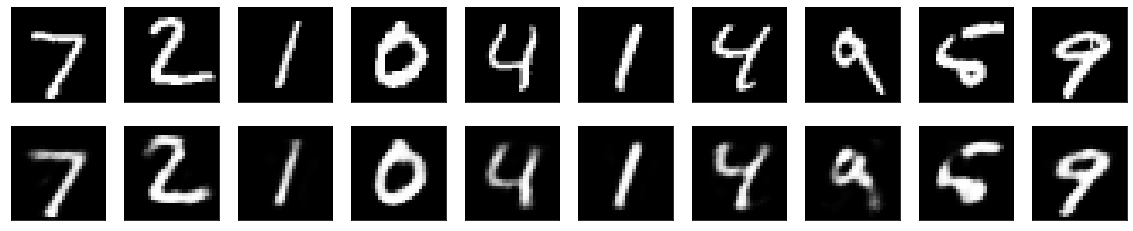

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
